#  Demo: Breast Cancer Diagnosis via Logistic Regression

In this demo, we will see how to visualize training data for classification, plot the logistic function and perform logistic regression.  As an example, we will use the widely-used breast cancer data set.  This data set is described here:

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin

Each sample is a collection of features that were manually recorded by a physician upon inspecting a sample of cells from fine needle aspiration.  The goal is to detect if the cells are benign or malignant.

We first load the packages as usual.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, preprocessing
%matplotlib inline

## Loading and Visualizing the Data

Next, we load the data.  It is important to remove the missing values.

In [2]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df.head(6)

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4


The first attribute, `id`, will not be used for prediction.  The last attribute, `class`, is the target variable and takes on the values {2,4}.  We will convert this to {0,1}, which is more standard.  Thus, there are 9 features in this dataset.

In [3]:
# Extract the targets.  Convert to a zero-one indicator 
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int)
Iben = (y==0) # indices of benign samples
Imal = (y==1) # indices of malignant samples

First, let's try using only two of the features, so that we can visualize what is going on.

In [4]:
# Choose two features
xnames =['size_unif','marg'] #size_unif, marg
X2 = np.array(df[xnames])

We now plot the target `y0` versus the two extracted features, which we'll call `x1` and `x2`. 
Since the features each take on values in {1,2,...,10}, we plot over 2D grid of 100 points. 
At each (`x1`,`x2`), we plot a red circle with a radius proportional to the number of malignant samples, and a green circle with a radius proportional to the number of benign samples. 
Since we will re-use this code, we define it as a function. 

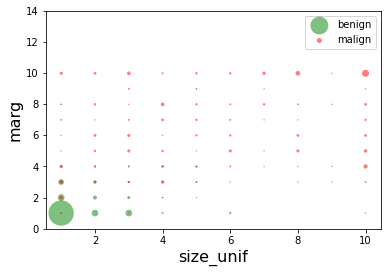

In [5]:
def plot_cnt(X,y):
    
    # Compute the bin edges for the 2d histogram
    x1val = np.array(list(set(X[:,0]))).astype(float)
    x2val = np.array(list(set(X[:,1]))).astype(float)
    x1, x2 = np.meshgrid(x1val,x2val)
    x1e= np.hstack((x1val,np.max(x1val)+1))
    x2e= np.hstack((x2val,np.max(x2val)+1))

    # Make a plot for each class
    yval = list(set(y))
    color = ['g','r']
    for i in range(len(yval)):
        I = np.where(y==yval[i])[0]
        cnt, x1e, x2e = np.histogram2d(X[I,0],X[I,1],[x1e,x2e])
        x1, x2 = np.meshgrid(x1val,x2val)
        plt.scatter(x1.ravel(), x2.ravel(), s=2*cnt.ravel(),alpha=0.5,
                    c=color[i],edgecolors='none')
    plt.ylim([0,14])
    plt.legend(['benign','malign'], loc='upper right')
    plt.xlabel(xnames[0], fontsize=16)
    plt.ylabel(xnames[1], fontsize=16)
    return plt

plot_cnt(X2,y);

The above plot gives some intuition about how these two features could be used to classify whether a given sample was bening or malignant.  Roughly speaking, we might predict that the sample is benign if both `marg` and `size_unif` are sufficiently small. 

## Least-Squares Linear Regression

As a first attempt in designing a classifier, let's apply the least-squares (LS) linear regression method that we studied in earlier units.  That is, let's treat the target `y` as a real number and try to predict it from `x0` and `x1`.

In [6]:
from sklearn import datasets, linear_model

regr = linear_model.LinearRegression()
regr.fit(X2,y)
print('regr.intercept=',regr.intercept_)
print('regr.coef=',regr.coef_)

regr.intercept= -0.08420066620061473
regr.coef= [0.10007944 0.04197521]


Because our target `y` takes on the value 0 for benign and 1 for malignant, we could assign a predicted value of less than 0.5 as benign and a predicted value of more than 0.5 as malignant. 
This rule partitions the (`x1`,`x2`) space linearly into two regions, as illustrated below.
The decision boundary occurs at $b + w_1 x_2 + w_2 x_2 = 0.5$, which can be rewritten as $x_2 = (0.5-b)/w_2 + (-w_1/w_2) x_1$, which is a line in the (`x1`,`x2`) space.

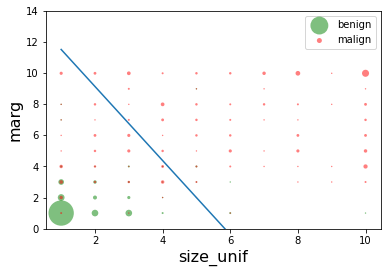

In [7]:
b=regr.intercept_
w1=regr.coef_[0]
w2=regr.coef_[1]

x1=np.zeros([10,1])
x2=np.zeros([10,1])
for i in range(10):
    x1[i]=i+1;
    x2[i]=(0.5-b-w1*(i+1))/w2

plt = plot_cnt(X2,y)
plt.plot(x1, x2);

Let's assess the accuracy of the 2-feature LS linear prediction as the percentage of correct classifications on the training data:

In [8]:
yhat = regr.predict(X2)
yhati = (yhat >=0.5).astype(int)
acc = np.mean(yhati == y)
print("Accuracy on training data using two features = %f" % acc)

Accuracy on training data using two features = 0.922401


And now let's repeat the LS-linear-prediction procedure using all 9 features.

In [9]:
xnames = ['thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit']
X = np.array(df[xnames])

regr.fit(X,y)
yhat=regr.predict(X)

yhati= (yhat >=0.5).astype(int)
acc = np.mean(yhati == y)
print("Accuracy on training data using 9 features = %f" % acc)

Accuracy on training data using 9 features = 0.960469


## Logistic Regression

In logistic regression, we fit the weights $b,w_1,w_2,\ldots,w_d$ in the model 
$$
    P\{y=1|z\} = \frac{1}{1+e^{-z}},  \quad z = b + w_1 x_1 + \cdots + w_d x_d,  
$$
The `sklearn` module provides a `LogisticRegression` object that does this.

In fact, the `LogisticRegression` object includes L2 regularization by default, with parameter `C` controlling the *inverse* regularization strength.  So, to simplify matters for now, let's set `C` very large to minimize the effects of L2 regularization.

In [10]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)

For visualization, let's first try logistic regression with only two features.
We would normally standardize the features `X` since we are using regularization, but we will avoid doing so for now in order to plot the decision boundary in the raw-feature space (to compare to the LS linear-regression case). 

In [11]:
logreg.fit(X2, y)
yhat = logreg.predict(X2)
acc = np.mean(yhat == y)
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 0.941435


We see that the accuracy of logistic regression is higher than with the LS linear predictor that we used earlier.
Next, let's plot the decision boundary for logistic regression.

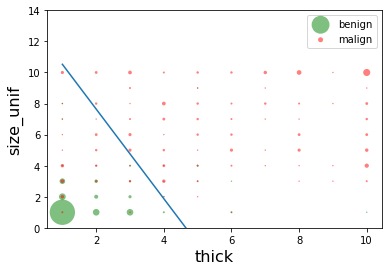

In [12]:
b = logreg.intercept_
w = np.array(logreg.coef_).T
w1 = w[0]
w2 = w[1]
x1=np.zeros([10,1])
x2=np.zeros([10,1])
for i in range(10):
    x1[i]=i+1;
    x2[i]=(0.5-b-w1*(i+1))/w2

plt = plot_cnt(X2,y)
plt.plot(x1, x2);

Relative to linear regression, the decision boundary has moved southwest and appears to better match the data.

Now let's try logistic regression with all 9 features.  We first standardize the `X` values because an L2 penalty is used by default.

In [13]:
Xs = preprocessing.scale(X)
logreg.fit(Xs, y);

We can next plot the accuracy on the training data.  We see we get an accuracy better than with LS linear regression, as used earlier. 

In [14]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 0.969253


It is also useful to print the weights for each feature.  We can use the `pandas` package to make a table. 

In [15]:
W = logreg.coef_.reshape(-1)
data = {'feature': xnames, 'slope': np.squeeze(W)}
dfslope = pd.DataFrame(data=data)
dfslope

,feature,slope
0,thick,1.508053
1,size_unif,-0.019233
2,shape_unif,0.963721
3,marg,0.946439
4,cell_size,0.214663
5,bare,1.394654
6,chrom,1.094675
7,normal,0.649846
8,mit,0.926017


## Cross validation

The above code measured the classification performance on the training data.  However, we should really measure performance on test data using cross-validation.  
So, we now perform 10-fold cross-validation and print average precision, recall, f1-score, and accuracy.
We use sklearn's `cross_validate` method because it can evaluate multiple metrics.

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# Instantiate KFold object
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True,random_state=42)

# Do cross-validation
cv_results = cross_validate(logreg, Xs, y, cv=kf, scoring=('precision', 'recall', 'f1', 'accuracy'))

# Extract test metrics
prec = cv_results['test_precision']
rec = cv_results['test_recall']
f1 = cv_results['test_f1']
acc = cv_results['test_accuracy']

# Take average values of the metrics
precm_unreg = np.mean(prec)
recm_unreg = np.mean(rec)
f1m_unreg = np.mean(f1)
accm_unreg= np.mean(acc)

# Compute the standard errors
prec_se_unreg = np.std(prec,ddof=1)/np.sqrt(nfold)
rec_se_unreg = np.std(rec,ddof=1)/np.sqrt(nfold)
f1_se_unreg = np.std(f1,ddof=1)/np.sqrt(nfold)
acc_se_unreg = np.std(acc,ddof=1)/np.sqrt(nfold)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm_unreg,prec_se_unreg))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm_unreg, rec_se_unreg))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m_unreg, f1_se_unreg))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm_unreg, acc_se_unreg))

Precision = 0.9581, SE=0.0153
Recall =    0.9533, SE=0.0138
f1 =        0.9543, SE=0.0087
Accuracy =  0.9678, SE=0.0061


## Confusion matrix

Next we will create the confusion matrix, which shows the four different outcomes that we can have in binary classification.  For this purpose, we can use sklearn's `confusion_matrix`, which takes in two vectors: one containing true labels `y` and the other containing predictions `yhat`.  We can use the `normalize='true'` option to make the rows sum to one, so that the $i$th row and $j$th column of the confusion matrix can be interpreted as sample estimates of $\text{Pr}\{\hat{y}=j\,|\,y=i\}$.

To compute the prediction vector `yhat`, we will use cross-validation.  This is conveniently implemented by sklearn's `cross_val_predict`.

Finally, we will use sklearn's `ConfusionMatrixDisplay` to create a nice plot.

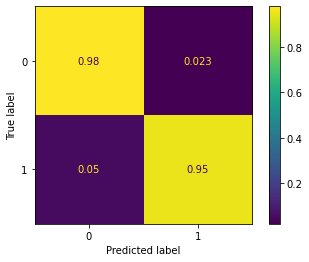

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Compute predictions using 10-fold cross-validation
yhat = cross_val_predict(logreg, Xs, y, cv=kf)

# Compute the (row-normalized) confusion matrix
C = confusion_matrix(y,yhat,normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=C)
disp.plot();

## ROC curve

As discussed above, the logistic regression classifier outputs a *soft* classification $P\{y=1|{\bf x}\}$. 
To get a *hard* classification, one could set $\hat{y}=1$ whenever $P\{y=1|{\bf x}\} > 0.5$. 
More generally, one could instead set $\hat{y}=1$ whenever $P\{y=1|{\bf x}\} > t$ for some other threshold $t$. 
Using a higher threshold would select $\hat{y}=1$ less often, which would result in fewer *false alarms* but more *missed detections* (i.e., reduced *sensitivity*). 
Likewise, a lower threshold value would select $\hat{y}=1$ more often, which would result in fewer *missed detections* (i.e., increased *sensitivity*) but more *false alarms*. 
The ROC curve helps to visualize this tradeoff by graphing the *true positive rate* $\Pr\{\hat{y}=1|y=1\}$ vs. the *false positive rate* $\Pr\{\hat{y}=1|y=0\}$ as the threshold $t$ is varied. 

The ROC curve can be plotted using the sklearn's `roc_curve` as follows.

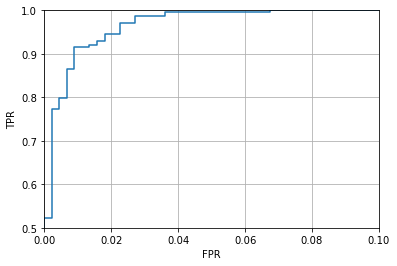

In [18]:
from sklearn import metrics
yprob = logreg.predict_proba(Xs)
fpr, tpr, thresholds = metrics.roc_curve(y,yprob[:,1])
thresholds[0] = 1

plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.5,1])
plt.xlim([0,0.1]);

Now let's see how the TPR and FPR vary as a function of the threshold.

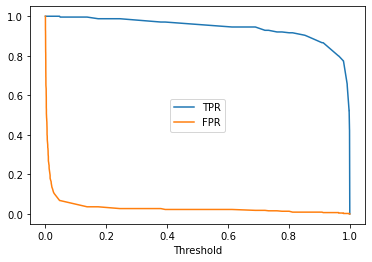

In [19]:
plt.plot(thresholds,tpr, thresholds,fpr)
plt.legend(['TPR','FPR'])
plt.xlabel('Threshold');

Similarly, we can see how the precision and recall vary as a function of the threshold.

In [20]:
py1 = np.mean(y==1)
py0 = np.mean(y==0)
pyhat1 = fpr*py0 + tpr*py1
precision = tpr*py1/pyhat1
recall = tpr

/var/folders/nn/74fn_c613bzckz1zkq8j58dh0000gn/T/ipykernel_14310/3314062036.py:4: RuntimeWarning: invalid value encountered in true_divide
  precision = tpr*py1/pyhat1


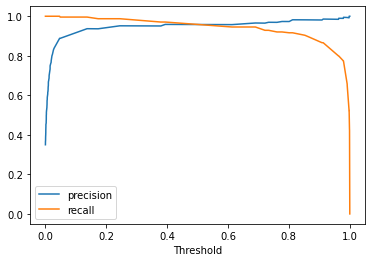

In [21]:
plt.plot(thresholds,precision, thresholds,recall)
plt.legend(['precision','recall'])
plt.xlabel('Threshold');

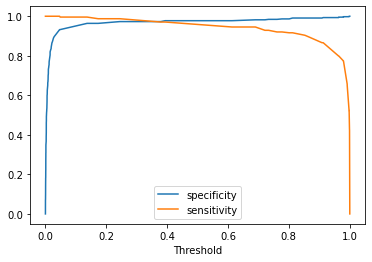

In [22]:
sensitivity = tpr
specificity = 1-fpr
plt.plot(thresholds,specificity, thresholds,sensitivity)
plt.legend(['specificity','sensitivity'])
plt.xlabel('Threshold');

And we can see how sensitivity and specificity vary as a function of the threshold.

To measure the goodness-of-classification in a threshold-*indepedent* manner, we can use the *area under the curve* (AUC). 
A higher AUC means that, for a given FPR, the PPR is higher. 
In practice, one should evalute UAC over different cross validation folds and report the mean AUC.

In [23]:
auc=metrics.roc_auc_score(y,yprob[:,1])
print("AUC=%f" % auc)

AUC=0.996325


## L1 regularization tuned for best "debiased" performance

As with LS linear regression (LinReg), we can add an L1 penalty in logistic regression (LogReg) to encourage fewer non-zero weight coefficients. 
This is particularly important when there are many features and not enough training samples. 
(In the current dataset, we have a sufficient number of samples for the number of features, and so we do not expect to see too much benefit from L1 regularization.)
In the classification context, the term "LASSO" is often used to mean L1-regularized LogReg, even though it was originally proposed as L1-regularized LinReg.

Like L1LinReg, L1LogReg sets a subset of coefficients to zero (which is good) but biases the remaining coefficients towards zero (which is bad).  
Thus it is common to "debias" L1LogReg by selecting the *indices* of its non-zero weights and recomputing the *values* of those weights using *unpenalized* LogReg.

The number of non-zero L1LogReg weights (i.e., number of selected features) is controlled by the strength of the regularization.
Actually, in sklearn, it is controlled by the *inverse* strength of the regularization, `C`.
We want to tune `C` to maximize the cross-validation performance of the final output (i.e., the output of *unpenalized* logistic regression).
This can be done by grid-search cross-validation: we make a grid of `C` values and then evaluate the cross-validation performance of L1LogReg+FeatureSelection+LogReg at each grid point.

Below, we implement this grid-search using a `for` loop. At each iteration, it fits L1LogReg to the full training data, identifies the selected features, and then cross-validates the performance of LogReg on those features using `cross_val_score`.

Note: if the `C` parameter grid contains values that cause L1LogReg to select zero features, the subsequent LogReg method will get confused and sklearn will print warnings. 
This is not a problem; you can just ignore those warnings.
But, to keep the demo code cleaner, we set the smallest `C` value in our grid to `1e-2.3`, so that L1LogReg selects at least one feature.

The C value corresponding to minimum error =   1.5283e-02
The minimum test error-rate =   2.9241e-02, SE=  6.1562e-03
The maximum test accuracy =  0.9708, SE=0.0062


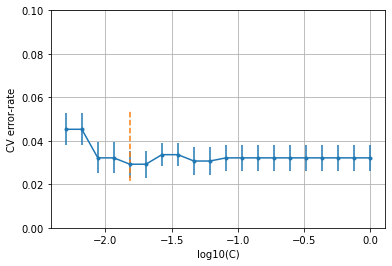

In [24]:
from sklearn.model_selection import cross_val_score

# instantiate L1LogReg
lasso = LogisticRegression(penalty='l1',solver='liblinear',warm_start=True)

# define tuning grid
npen = 20
C_lasso = np.logspace(-2.3,0,npen) 

# grid-search cross-validation
err_mean = np.ones(len(C_lasso))
err_se = np.zeros(len(C_lasso))
for i,c in enumerate(C_lasso):
    # fit L1LogReg
    lasso.set_params(C=c)
    lasso.fit(Xs,y)
    # select features
    nonzero = np.any((lasso.coef_)>1e-5,axis=0) # test nonzero
    subset = np.where(nonzero)[0] # array of feature indices
    if len(subset)>0:
        # evaluate LogReg performance using CV
        err = 1-cross_val_score(logreg, Xs[:,subset], y, cv=kf, scoring='accuracy')
        err_mean[i] = np.mean(err)
        err_se[i] = np.std(err,ddof=1) / np.sqrt(nfold)

# extract best design
imin = np.argmin(err_mean)
C_min = C_lasso[imin]

# plot error versus C
plt.errorbar(np.log10(C_lasso),err_mean,yerr=err_se,marker='.')
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(np.log10([C_min,C_min]),[ymin,ymax],'--')
plt.ylim([0.0,0.1])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('CV error-rate')

print("The C value corresponding to minimum error = %12.4e" % C_min)
print("The minimum test error-rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))
print('The maximum test accuracy =  {0:.4f}, SE={1:.4f}'.format(1-err_mean[imin], err_se[imin]))

As an alternative to selecting the `C` that minimizes the CV error rate, we could instead choose `C` according to the one-standard-error rule.  In doing so, we must remember that a smaller `C` signifies a larger regularization strength and thus a simpler model.

One-standard-error-rule C=  8.7520e-03
The OSE test-error rate =   3.2161e-02, SE=  7.1315e-03
The OSE accuracy =  0.9678, SE=0.0071


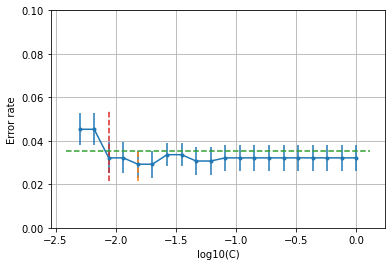

In [25]:
# one-standard-error rule
err_tgt = err_mean[imin] + err_se[imin]
iose = np.where(err_mean < err_tgt)[0][0]
C_ose = C_lasso[iose]

# plot error versus C
plt.errorbar(np.log10(C_lasso), err_mean, marker='.',yerr=err_se)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(np.log10([C_min,C_min]),[ymin,err_tgt],'--')
plt.plot([xmin,xmax],[err_tgt,err_tgt],'--')
plt.plot(np.log10([C_ose,C_ose]),[ymin,ymax],'--')
plt.ylim([0.0,0.1])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')

print("One-standard-error-rule C=%12.4e" % C_ose)
print("The OSE test-error rate = %12.4e, SE=%12.4e" % (err_mean[iose], err_se[iose]))
print('The OSE accuracy =  {0:.4f}, SE={1:.4f}'.format(1-err_mean[iose], err_se[iose]))

Next, we plot the weight values computed by the various methods. 
First we examine LogReg without any regularization, which we computed earlier in this demo.
Next we examine L1LogReg using the `C_min` value found above. 
Finally, we examine LogReg (without regularization) trained on the features selected by L1LogReg.

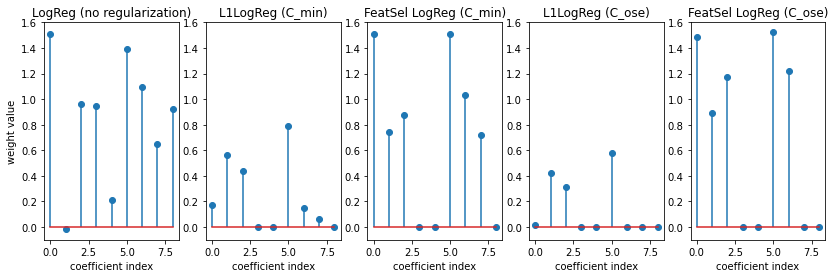

In [26]:
# fit to entire training data under C_min
lasso.set_params(C=C_min)
lasso.fit(Xs,y)
nonzero = np.any((lasso.coef_)>1e-5,axis=0) # test nonzero
subset = np.where(nonzero)[0] # array of feature indices
logreg.fit(Xs[:,subset],y)
W_lasso_Cmin = lasso.coef_.reshape(-1)
W_logreg_Cmin = np.zeros(W_lasso_Cmin.shape)
W_logreg_Cmin[subset] = logreg.coef_.reshape(-1)

# fit to entire training data under C_ose
lasso.set_params(C=C_ose)
lasso.fit(Xs,y)
nonzero = np.any((lasso.coef_)>1e-5,axis=0) # test nonzero
subset = np.where(nonzero)[0] # array of feature indices
logreg.fit(Xs[:,subset],y)
W_lasso_Cose = lasso.coef_.reshape(-1)
W_logreg_Cose = np.zeros(W_lasso_Cose.shape)
W_logreg_Cose[subset] = logreg.coef_.reshape(-1)

# plot weight values
plt.figure(figsize=(14,4))
plt.subplot(1,5,1)
plt.stem(W)
plt.ylim([-0.1,1.6])
plt.title('LogReg (no regularization)')
plt.ylabel('weight value')
plt.xlabel('coefficient index')
plt.subplot(1,5,2)
plt.stem(W_lasso_Cmin)
plt.ylim([-0.1,1.6])
plt.title('L1LogReg (C_min)')
plt.xlabel('coefficient index')
plt.subplot(1,5,3)
plt.stem(W_logreg_Cmin)
plt.ylim([-0.1,1.6])
plt.title('FeatSel LogReg (C_min)')
plt.xlabel('coefficient index')
plt.subplot(1,5,4)
plt.stem(W_lasso_Cose)
plt.ylim([-0.1,1.6])
plt.title('L1LogReg (C_ose)')
plt.xlabel('coefficient index')
plt.subplot(1,5,5)
plt.stem(W_logreg_Cose)
plt.ylim([-0.1,1.6])
plt.title('FeatSel LogReg (C_ose)')
plt.xlabel('coefficient index');

The results above are as expected.
First, with unregularized LogReg, all weights are nonzero.
When we add the L1 penalty under strength `C_min`, a subset of weights goes to zero and the remaining weights shrink.
Debiasing the design preserves the subset of non-zero weights but allows larger weight values (and, more importantly, values that work better for classification).
When we use the L1 penalty under strength `C_ose`, one more weight goes to zero.

## L1 regularization tuned for best "debiased" performance using a pipeline

As we saw above, it is possible to tune L1LogReg for best "debiased" performance using a `for` loop. 
But we also know that sklearn's `GridSearchCV` provides an alternative to `for`-loop based cross-validation: it requires us to specify only the estimator, the parameter grid, the cross-val object, and the performance metric. 
But when the estimator is a cascade of operations like L1LogReg+FeatureSelection+LogReg, how do we pass it to `GridSearchCV`?
The answer is provided by sklearn's `Pipeline` framework, which allows one to cascade several estimators together.
In the pipeline, we can use sklearn's `SelectFromModel` transform to do the FeatureSelection step.

The code below first creates a pipeline with two steps: 1) L1LogReg followed by `SelectFromModel`, and 2) unregularized LogReg.  
We need to put `SelectFromModel` together with L1LogReg in one step because `SelectFromModel` does not have a "fit" method, as required for all components of a pipeline.
Once we build the pipeline, we can pass it into `GridSearchCV` as the estimator. 
We'll also pass in the same `C` grid, `kf` cross-validation object, and `accuracy` metric as before.


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

# build pipeline for L1LogReg+FeaturesSelect+LogReg
pipe = Pipeline([
  ('featsel',SelectFromModel(LogisticRegression(penalty='l1',solver='liblinear',warm_start=True))),
  ('logreg', LogisticRegression(C=1e5))
])

# tune L1LogReg regularization strength
npen = 20
C_lasso = np.logspace(-2.3,0,npen) # grid of C values
parameters = {'featsel__estimator__C':C_lasso} # see pipe.get_params().keys()
gscv = GridSearchCV(pipe, parameters, cv=kf, scoring='accuracy')
gscv.fit(Xs,y);

Now that our CV procedure has finished running, we can extract the results using the `.best_score_`, `.best_params_`, and `.best_estimator_` methods. 
Note that the `.best_estimator_` is fit to the entire training dataset using the best parameters.
Below, we also plot the mean error-rate estimated by cross-validation versus `C`, as well as its standard error.

Best CV accuracy = 0.9707800511508952
Best parameters = {'featsel__estimator__C': 0.015283067326587695}
Numerical value of best C parameter = 0.015283067326587695
The minimum test error rate =   2.9220e-02, SE=  6.8576e-03
The C value corresponding to minimum error =   1.5283e-02


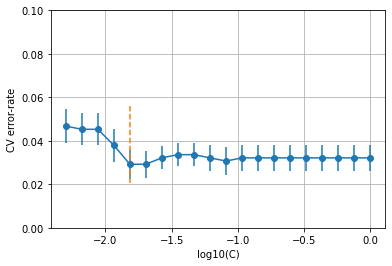

In [28]:
# extract results of tuning
print("Best CV accuracy = "+str(gscv.best_score_))
print("Best parameters = "+str(gscv.best_params_))
C_best = gscv.best_estimator_.named_steps["featsel"].estimator.C
print("Numerical value of best C parameter = "+str(C_best))

# Average test results across folds
err_mean = 1-gscv.cv_results_['mean_test_score'] # error-rate = 1-accuracy
err_se = gscv.cv_results_['std_test_score']/np.sqrt(nfold-1)
imin = np.argmin(err_mean)
C_min = C_lasso[imin] # should agree with C_best above

# Plot error statistics versus C
plt.errorbar(np.log10(C_lasso), err_mean, marker='o',yerr=err_se)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(np.log10([C_min,C_min]),[ymin,ymax],'--')
plt.ylim([0.0,0.1])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('CV error-rate')

print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = %12.4e" % C_min)

If you look closely at the CV error-rates above, you'll see that they are slightly different from the ones computed by the `for`-loop method, even though we used the same estimator, k-fold method, and metric. 
This is because the two techniques differ slightly in *how* the L1LogReg stage is trained: 
In the `for`-loop method, L1LogReg is trained once using the full data, but in the pipeline method, L1LogReg is trained K times on different folds.
Because each fold can yield a different number of non-zero weights, the mean-error-rate curve is not piecewise constant as it was in the `for` loop method.
Furthermore, the pipeline method is slower to train because the most expensive stage (L1LogReg) is run K times more often.

Next, we plot the weight values computed by the various methods in the pipeline. 

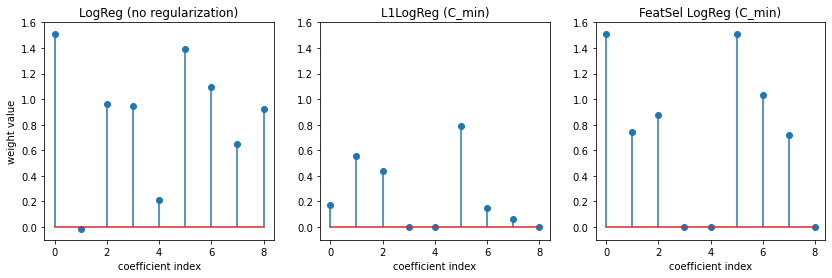

In [29]:
# best estimator
pipe_best = gscv.best_estimator_ 

# L1LogReg coefficients
W_l1 = pipe_best.named_steps["featsel"].estimator_.coef_.reshape(-1)
support = pipe_best.named_steps["featsel"].get_support()

# LogReg coefficients
W_pipe = np.zeros(W.shape)
W_pipe[support] = pipe_best.named_steps["logreg"].coef_.reshape(-1)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.stem(W)
plt.ylim([-0.1,1.6])
plt.title('LogReg (no regularization)')
plt.ylabel('weight value')
plt.xlabel('coefficient index')
plt.subplot(1,3,2)
plt.stem(W_l1)
plt.ylim([-0.1,1.6])
plt.title('L1LogReg (C_min)')
plt.xlabel('coefficient index')
plt.subplot(1,3,3)
plt.stem(W_pipe)
plt.ylim([-0.1,1.6])
plt.title('FeatSel LogReg (C_min)')
plt.xlabel('coefficient index');

The results above are as expected.
First, with unregularized LogReg, all weights are nonzero.
When we add the L1 penalty, a subset of weights goes to zero and the remaining weights shrink.
Finally, when unregularized LogReg is fit to the L1LogReg-selected features alone, the non-zero weights grow larger. 
More importantly, those weights work better for classification, as we show below.

Finally we evaluate the cross-val-selected best estimator according to several other metrics: precision, recall, and f1. 
As before, we do this easily using the `cross_validate` method.

In [30]:
# evaluate best estimator
cv_results = cross_validate(pipe_best, Xs, y, cv=kf, scoring=('precision', 'recall', 'f1', 'accuracy'))

# Extract test metrics
prec = cv_results['test_precision']
rec = cv_results['test_recall']
f1 = cv_results['test_f1']
acc = cv_results['test_accuracy']

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

# Compute the standard errors
prec_se = np.std(prec,ddof=1)/np.sqrt(nfold)
rec_se = np.std(rec,ddof=1)/np.sqrt(nfold)
f1_se = np.std(f1,ddof=1)/np.sqrt(nfold)
acc_se = np.std(acc,ddof=1)/np.sqrt(nfold)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

Precision = 0.9621, SE=0.0131
Recall =    0.9586, SE=0.0144
f1 =        0.9593, SE=0.0091
Accuracy =  0.9708, SE=0.0069


The results above show that, by using L1-LogReg to perform feature selection, we can improve the performance relative to non-feature-selected LogReg.

## L1 regularization tuned for best "biased" performance

There is one downside to the above approach to L1LogReg that arises in classification with K>2 classes: we might want to allow different predictors to use *different subsets of features*.
With the "debiased" approach above, all K predictors are forced to use the same subset of features.
Furthermore, a feature is discarded only when its weight equals zero in all K predictors! 
Thus, as K grows larger, it becomes more difficult to do feature selection.

If we want to allow different predictors to use different subsets of features, then we can't use the debiased approach from earlier. 
An alternative is to train L1LogReg and use the learned weight values as-is, even though they are biased. 
For tuning, we could just use grid-search cross-validation as usual, or we could use the one-standard-error rule (which further increases sparsity).

Because this demo considers binary classification, this alternative approach will have no advantage over the debiased approach described earlier.
Still, we will implement it for completeness and compare it to the debiased approach.

The first step is to instantiate L1LogReg and run grid-search cross-validation to tune its regularization strength `C` over a grid. 
We then plot the resulting CV-estimated error rate (and its standard error) versus `C`.

The minimum test error rate =   2.9220e-02, SE=  4.8386e-03
The C value corresponding to minimum error =   1.5283e-02


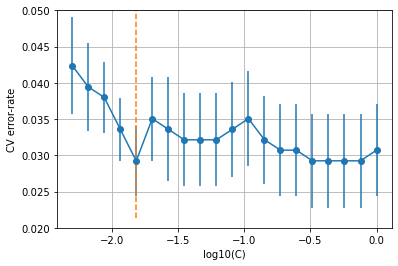

In [31]:
# Create the lasso object
lasso = LogisticRegression(penalty='l1', solver='liblinear', warm_start=True)

# Define the parameter grid
npen = 20
C_lasso = np.logspace(-2.3,0,npen)

# Run cross-validation
parameters = {'C':C_lasso}
clf = GridSearchCV(lasso, parameters, cv=kf, scoring='accuracy')
clf.fit(Xs,y)

# Average test results across folds
err_mean = 1-clf.cv_results_['mean_test_score'] # error-rate = 1-accuracy
err_se = clf.cv_results_['std_test_score']/np.sqrt(nfold-1)
imin = np.argmin(err_mean)
C_min = C_lasso[imin]

# Plot error statistics versus C
plt.errorbar(np.log10(C_lasso), err_mean, marker='o',yerr=err_se)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(np.log10([C_min,C_min]),[ymin,ymax],'--')
plt.ylim([0.02,0.05])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('CV error-rate')

print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))
print("The C value corresponding to minimum error = %12.4e" % C_min)

Now we choose `C` using the one-standard-error rule. 
Note that, because smaller `C` implies a simpler model, we want to find the *smallest* `C` that satisfies the error target. 
We also print the corresponding test accuracy with this choice of `C`.

One-standard-error-rule C=  1.1565e-02
The test error rate =   3.3610e-02, SE=  4.3255e-03
Accuracy =  0.9664, SE=0.0043


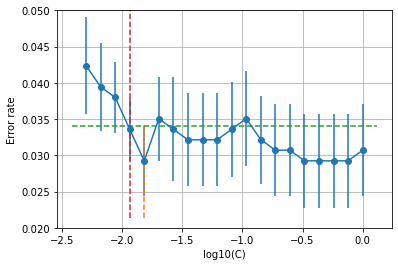

In [32]:
# One-standard-error rule
err_tgt = err_mean[imin] + err_se[imin]
iose = np.where(err_mean < err_tgt)[0][0]
C_ose = C_lasso[iose]

# Plot error statistics versus C
plt.errorbar(np.log10(C_lasso), err_mean, marker='o',yerr=err_se)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(np.log10([C_min,C_min]),[ymin,err_tgt],'--')
plt.plot([xmin,xmax],[err_tgt,err_tgt],'--')
plt.plot(np.log10([C_ose,C_ose]),[ymin,ymax],'--')
plt.ylim([0.02,0.05])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')

print("One-standard-error-rule C=%12.4e" % C_ose)
print("The test error rate = %12.4e, SE=%12.4e" % (err_mean[iose], err_se[iose]))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(1-err_mean[iose], err_se[iose]))

For the selected `C`, we now fit L1LogReg on the entire training data and plot the resulting weights.  We can compare these weights to unregularized LogReg.  We can see that, with L1-regularization, the weight vector is much more sparse, but the non-zero coefficients have shrunk.

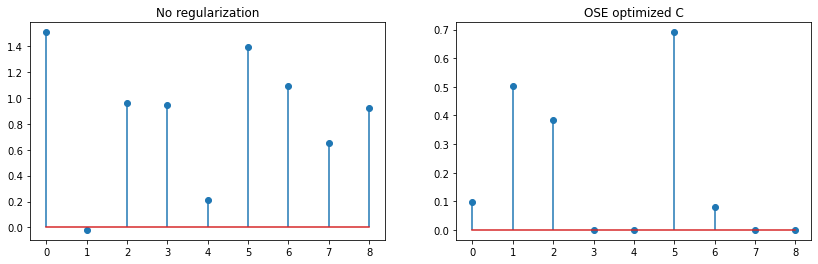

In [33]:
# Re-fit LASSO on entire training data
lasso = LogisticRegression(C=C_ose,penalty='l1',solver='liblinear')
lasso.fit(Xs,y)
W_ose = lasso.coef_.reshape(-1)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.stem(W)
plt.title('No regularization')
plt.subplot(1,2,2)
plt.stem(W_ose)
plt.title('OSE optimized C')

# Extract feature indices 
subset = np.where(np.abs(W_ose)>0)[0]

Finally we evaluate this OSE-tuned classifier on the full set of metrics.

In [34]:
# Do cross-validation
cv_results = cross_validate(lasso, Xs, y, cv=kf, scoring=('precision', 'recall', 'f1', 'accuracy'))

# Extract test metrics
prec = cv_results['test_precision']
rec = cv_results['test_recall']
f1 = cv_results['test_f1']
acc = cv_results['test_accuracy']

# Take average values of the metrics
precm_ose = np.mean(prec)
recm_ose = np.mean(rec)
f1m_ose = np.mean(f1)
accm_ose = np.mean(acc)

# Compute the standard errors
prec_se_ose = np.std(prec,ddof=1)/np.sqrt(nfold)
rec_se_ose = np.std(rec,ddof=1)/np.sqrt(nfold)
f1_se_ose = np.std(f1,ddof=1)/np.sqrt(nfold)
acc_se_ose = np.std(acc,ddof=1)/np.sqrt(nfold)

print('OSE results:')
print('Precision = {0:.4f}, SE={1:.4f}'.format(precm_ose,prec_se_ose))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm_ose, rec_se_ose))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m_ose, f1_se_ose))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm_ose, acc_se_ose))
print('')
print('Pipeline results:')
print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))
print('')
print('Unregularized results:')
print('Precision = {0:.4f}, SE={1:.4f}'.format(precm_unreg,prec_se_unreg))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm_unreg, rec_se_unreg))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m_unreg, f1_se_unreg))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm_unreg, acc_se_unreg))

OSE results:
Precision = 0.9473, SE=0.0126
Recall =    0.9603, SE=0.0113
f1 =        0.9526, SE=0.0056
Accuracy =  0.9664, SE=0.0043

Pipeline results:
Precision = 0.9621, SE=0.0131
Recall =    0.9586, SE=0.0144
f1 =        0.9593, SE=0.0091
Accuracy =  0.9708, SE=0.0069

Unregularized results:
Precision = 0.9581, SE=0.0153
Recall =    0.9533, SE=0.0138
f1 =        0.9543, SE=0.0087
Accuracy =  0.9678, SE=0.0061


As you can see, the accuracy of the OSE approach is not as good as that of the pipeline approach, nor the unregularized approach, because the L1LogReg coefficients are biased towards zero. 

However, it should be noted that the results will vary based on the cross-validation split, which is random.  In this demo, we fixed the random seed of the cross-validation split to suppress this randomness, but changing the  seed value will slightly change the results.

Also, it should be noted that the benefits of feature selection are very much dependent on the dataset. 
In datasets where the number of features is large compared to the number of samples, feature selection is essential. 
In this breast-cancer dataset, feature selection does not have a profound effect.